# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [4]:
def apk(relevant, predicted, k):
    if not relevant:
        return 1

    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0
    num_hits = 0

    for i,p in enumerate(predicted):
        if p in relevant and p not in predicted[:i]:
            num_hits += 1
            score += num_hits / (i + 1)

    return score / min(len(relevant), k)

In [5]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    return np.mean([apk(relevant[i], predicted[i], k) for i in range(len(relevant))])

In [6]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [7]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [8]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [9]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [10]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [11]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [12]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [13]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [14]:
n_users = len(np.unique(train_ratings['userId']))
n_items = len(np.unique(train_ratings['trackId']))

R = np.zeros((n_users, n_items))
R[train_ratings['userId'], train_ratings['trackId']] = 1.

In [15]:
new_preds = np.zeros((len(R), 10), dtype=int)
for user_id, user_data in train_ratings.groupby('userId'):
    user_preds = R[user_id]
    new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:10]
new_preds

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [17]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        test_users = self.ratings['userId'].unique()
        
        for uid in test_users:
            recommendations = self.recommend(uid)
            test_preds.append(recommendations)
        
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [18]:
l = np.array([[0, 1, 1, 0, 1], [0, 0, 1, 0, 1], [0, 0, 1, 0, 0]])
indices, values = np.where(l > 0)

In [19]:
values[np.where(indices == 0)]

array([1, 2, 4])

In [20]:
indices, values

(array([0, 0, 0, 1, 1, 2]), array([1, 2, 4, 2, 4, 2]))

In [21]:
def pearson_1d(user1_idx, user2_idx, user1_vector, user2_vector):
    intersection_idx = np.intersect1d(user1_idx, user2_idx)
    similarity = np.sum(user1_vector[intersection_idx] * user2_vector[intersection_idx]) / \
        np.sqrt(np.sum(user1_vector[user1_idx] ** 2)) / \
            np.sqrt(np.sum(user2_vector[user2_idx] ** 2))
    return similarity

def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    user_idx = np.where(user_vector > 0)[0]
    if len(user_idx) == 0:
        return [0] * ratings.shape[0]
    
    indices, values = np.where(ratings > 0)
    similarity = []
    for i in range(ratings.shape[0]):
        another_user_idx = values[np.where(indices == i)]
        if len(another_user_idx) > 0:
            similarity.append(pearson_1d(user_idx, another_user_idx, user_vector, ratings[i, :]))
        else:
            similarity.append(0)
    return similarity


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    ones = np.ones(ratings.shape)
    intersection = (ones * ((ratings > 0) & (user_vector > 0))).sum(axis=1)
    union = (ones * ((ratings > 0) | (user_vector > 0))).sum(axis=1)
    similarity = intersection / (union + 1e-10)
    return similarity

In [22]:
ratings = np.array([
    [5, 3, 0, 0, 2],
    [4, 0, 0, 3, 3],
    [1, 1, 0, 5, 4],
    [0, 0, 0, 0, 0],
    [0, 0, 5, 4, 4]
])
user_vector = np.array([5, 3, 0, 0, 2])

pearson_similarities = pearson(ratings, user_vector)
jaccard_similarities = jaccard(ratings, user_vector)

print("Jaccard similarities:", jaccard_similarities)
print("Pearson similarities:", pearson_similarities)

Jaccard similarities: [1.   0.5  0.75 0.   0.2 ]
Pearson similarities: [1.0000000000000002, 0.7233393492970543, 0.3958165567962348, 0, 0.171894017037416]


**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

In [23]:
ratings[:, 0]

array([5, 4, 1, 0, 0])

In [24]:
np.multiply(ratings.T, ratings[:, 0]).T

array([[25, 15,  0,  0, 10],
       [16,  0,  0, 12, 12],
       [ 1,  1,  0,  5,  4],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0]])

In [25]:
ratings

array([[5, 3, 0, 0, 2],
       [4, 0, 0, 3, 3],
       [1, 1, 0, 5, 4],
       [0, 0, 0, 0, 0],
       [0, 0, 5, 4, 4]])

In [26]:
uid = 0
alfa = 0.02
user_vector = ratings[uid, :]
similarities = jaccard(ratings, user_vector)
print(similarities)
users_sim_idx = np.where(similarities > alfa)[0]
another_users_similarities = similarities[users_sim_idx[np.where(users_sim_idx != uid)]]
print(another_users_similarities)
recommendations = np.multiply(ratings.T, similarities).T
print(recommendations)
recommendations = np.sum(recommendations[np.delete(np.where(similarities > alfa), uid), :], axis=0)
print(recommendations)
recommendations /= np.sum(another_users_similarities)
print(recommendations)
np.argsort(-recommendations)

[1.   0.5  0.75 0.   0.2 ]
[0.5  0.75 0.2 ]
[[5.   3.   0.   0.   2.  ]
 [2.   0.   0.   1.5  1.5 ]
 [0.75 0.75 0.   3.75 3.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.8  0.8 ]]
[2.75 0.75 1.   6.05 5.3 ]
[1.89655172 0.51724138 0.68965517 4.17241379 3.65517241]


array([3, 4, 0, 2, 1])

In [27]:
np.sum(ratings[:, 0])

10

In [28]:
np.sum(np.multiply(ratings.T, ratings[:, 0]).T, axis=0) / np.sum(ratings[:, 0])

array([4.2, 1.6, 0. , 1.7, 2.6])

In [29]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        user_vector = self.R[uid, :]
        similarities = np.array(self.similarity(user_vector))
        users_sim_idx = np.where(similarities > self.alpha)[0]
        users_sim_idx = users_sim_idx[np.where(users_sim_idx != uid)]
        another_users_similarities = similarities[users_sim_idx]
        recommendations = np.multiply(self.R.T, similarities).T
        recommendations = np.sum(recommendations[users_sim_idx, :], axis=0)
        recommendations /= np.sum(another_users_similarities)
        return np.argsort(-recommendations)

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [30]:
class RandomModel(BaseModel):
    def recommend(self, uid: int):
        all_items = np.arange(self.n_items)
        return np.random.choice(all_items, size=self.n_items, replace=False)

In [31]:
user2user_pearson = User2User(train_ratings, pearson)
user2user_jaccard = User2User(train_ratings, jaccard)
random_model = RandomModel(train_ratings)

/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_11138/4004935027.py:24: RuntimeWarning: invalid value encountered in divide
  recommendations /= np.sum(another_users_similarities)


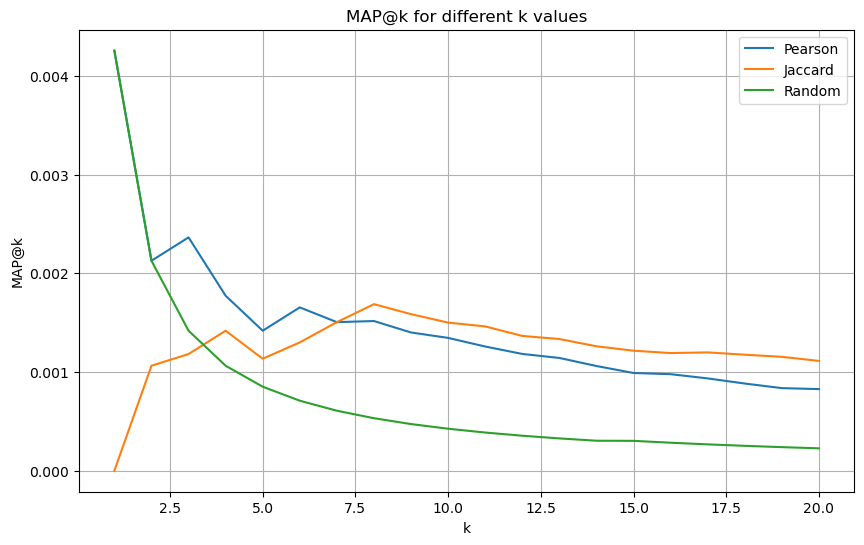

In [32]:
ks = list(range(1, 21))
results_pearson = []
results_jaccard = []
results_random = []
test_recommendation = test_ratings.groupby('userId')['trackId'].apply(list)

preds_pearson = user2user_pearson.get_test_recommendations(max(ks))
preds_jaccard = user2user_jaccard.get_test_recommendations(max(ks))
preds_random = random_model.get_test_recommendations(max(ks))

for k in ks:
    mapk_pearson = mapk(list(test_recommendation), preds_pearson, k)
    mapk_jaccard = mapk(list(test_recommendation), preds_jaccard, k)
    mapk_random = mapk(list(test_recommendation), preds_random, k)
    
    results_pearson.append(mapk_pearson)
    results_jaccard.append(mapk_jaccard)
    results_random.append(mapk_random)

# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(ks, results_pearson, label='Pearson')
plt.plot(ks, results_jaccard, label='Jaccard')
plt.plot(ks, results_random, label='Random')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k for different k values')
plt.legend()
plt.grid(True)
plt.show()

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [32]:
def to_sparse_matrix(ratings, shape):
    rows = ratings['userId'].values
    cols = ratings['trackId'].values
    data = np.ones(len(ratings))
    return scs.csc_matrix((data, (rows, cols)), shape=shape)

to_sparse_matrix(train_ratings, (len(uencoder.classes_), len(iencoder.classes_))).nonzero()#[1]#.__len__()#.indices#.__len__()#.count_nonzero()

(array([  0,   0,   0, ..., 240, 240, 240], dtype=int32),
 array([   14,    95,   219, ..., 65480, 65515, 65518], dtype=int32))

In [33]:
sprs = to_sparse_matrix(train_ratings, (len(uencoder.classes_), len(iencoder.classes_))).T
sprs.multiply([0.0]*240+[1]).T.sum(axis=0)#.nonzero()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

In [34]:
def sparse_pearson_1d(user1_idx, user2_idx):
    intersection_idx = np.intersect1d(user1_idx, user2_idx)
    similarity = len(intersection_idx) / \
                    np.sqrt(len(user1_idx)) / \
                    np.sqrt(len(user2_idx))
    return similarity

def sparse_pearson(ratings: scs.sparray, user_idx: np.array) -> np.array:
    if len(user_idx) == 0:
        return [0] * ratings.shape[0]
    
    similarity = []
    for i in range(ratings.shape[0]):
        another_user_idx = ratings[[i]].nonzero()[1]
        if len(another_user_idx) > 0:
            similarity.append(sparse_pearson_1d(user_idx, another_user_idx))
        else:
            similarity.append(0)
    return similarity

def sparse_jaccard(ratings: scs.sparray, user_idx: np.array) -> np.array:
    similarity = []
    for i in range(ratings.shape[0]):
        another_user_idx = ratings[[i]].nonzero()[1]
        intersection_idx = np.intersect1d(another_user_idx, user_idx)
        union_idx = np.union1d(another_user_idx, user_idx)
        similarity.append(len(intersection_idx) / (len(union_idx) + 1e-10))
    return similarity

In [35]:
class BaseSparseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.ratings_sparse = self.to_sparse_matrix()
        
    def to_sparse_matrix(self):
        rows = self.ratings['userId'].values
        cols = self.ratings['trackId'].values
        data = np.ones(len(self.ratings))
        return scs.csc_array((data, (rows, cols)), shape=(self.n_users, self.n_items))

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        test_users = self.ratings['userId'].unique()
        
        for uid in test_users:
            recommendations = self.recommend(uid)
            test_preds.append(recommendations)
        
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds


class SparseUser2User(BaseSparseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [sparse_pearson, sparse_jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_idx: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.ratings_sparse, user_idx)

    def recommend(self, uid: int):
        user_idx = self.ratings_sparse[[uid]].nonzero()[1]

        similarities = np.array(self.similarity(user_idx))

        users_sim_idx = np.where(similarities > self.alpha)[0]
        users_sim_idx = users_sim_idx[np.where(users_sim_idx != uid)]
        another_users_similarities = similarities[users_sim_idx]

        recommendations = np.multiply(self.ratings_sparse.toarray().T, similarities).T
        recommendations = np.sum(recommendations[users_sim_idx, :], axis=0)
        recommendations /= np.sum(another_users_similarities)
        #recommendations = self.ratings_sparse.T.multiply(similarities).T.tocsc()#.sum(axis=0)
        #recommendations = np.sum(recommendations[users_sim_idx], axis=0)
        #recommendations = recommendations / np.sum(another_users_similarities)
        
        return np.argsort(-recommendations)


/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_7897/1997745161.py:73: RuntimeWarning: invalid value encountered in divide
  recommendations /= np.sum(another_users_similarities)


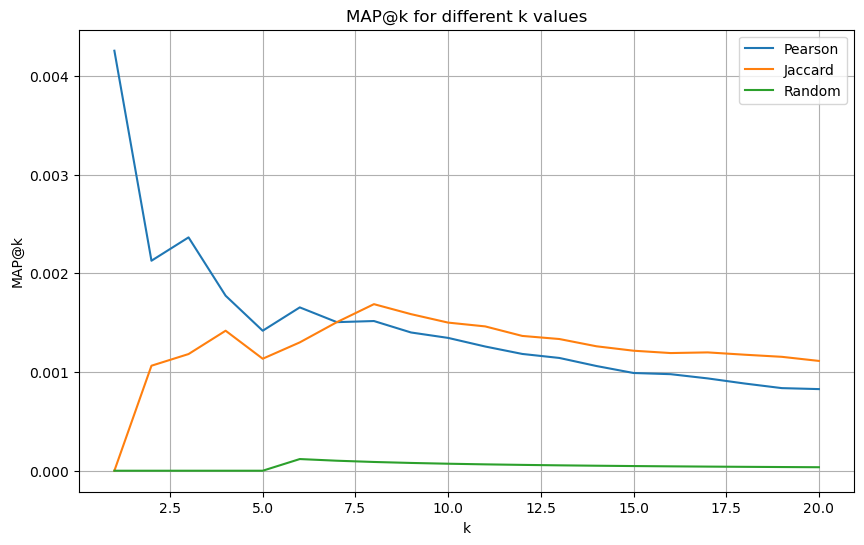

In [346]:
sparse_user2user_pearson = SparseUser2User(train_ratings, sparse_pearson)
sparse_user2user_jaccard = SparseUser2User(train_ratings, sparse_jaccard)
random_model = RandomModel(train_ratings)

ks = list(range(1, 21))
results_sparse_pearson = []
results_sparse_jaccard = []
results_random = []
test_recommendation = test_ratings.groupby('userId')['trackId'].apply(list)

preds_sparse_pearson = sparse_user2user_pearson.get_test_recommendations(max(ks))
preds_sparse_jaccard = sparse_user2user_jaccard.get_test_recommendations(max(ks))
preds_random = random_model.get_test_recommendations(max(ks))

for k in ks:
    mapk_pearson = mapk(list(test_recommendation), preds_sparse_pearson, k)
    mapk_jaccard = mapk(list(test_recommendation), preds_sparse_jaccard, k)
    mapk_random = mapk(list(test_recommendation), preds_random, k)
    
    results_sparse_pearson.append(mapk_pearson)
    results_sparse_jaccard.append(mapk_jaccard)
    results_random.append(mapk_random)

# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(ks, results_sparse_pearson, label='Pearson')
plt.plot(ks, results_sparse_jaccard, label='Jaccard')
plt.plot(ks, results_random, label='Random')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k for different k values')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_7897/24390973.py:26: RuntimeWarning: invalid value encountered in divide
  recommendations /= np.sum(another_users_similarities)
/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_7897/1997745161.py:73: RuntimeWarning: invalid value encountered in divide
  recommendations /= np.sum(another_users_similarities)


Original model MAP@20: 0.0008, Time: 39.8932s
Sparse model MAP@20: 0.0008, Time: 68.1849s
Original model MAP@20: 0.0011, Time: 41.0724s
Sparse model MAP@20: 0.0011, Time: 64.9145s


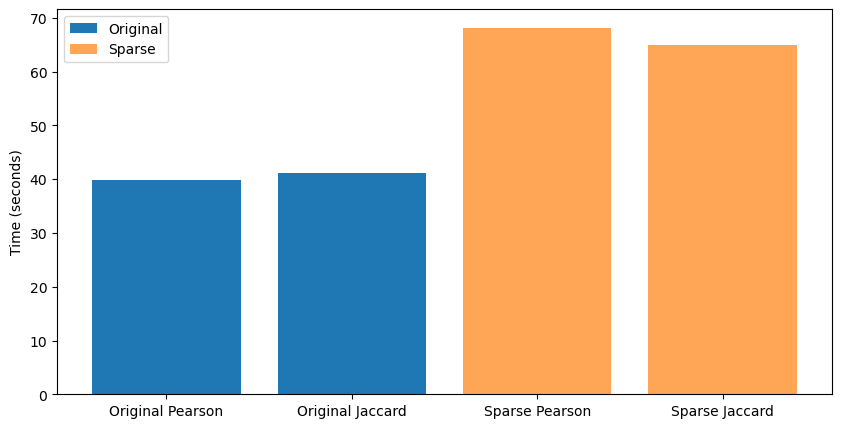

In [347]:
import time

def measure_time(model, k, test_recommendation):
    start_time = time.time()
    preds = model.get_test_recommendations(k)
    duration = time.time() - start_time
    mapk_score = mapk(list(test_recommendation), preds, k)
    return duration, mapk_score

# Оригинальные модели
user2user_pearson = User2User(train_ratings, pearson)
user2user_jaccard = User2User(train_ratings, jaccard)

# Разреженные модели
sparse_user2user_pearson = SparseUser2User(train_ratings, sparse_pearson)
sparse_user2user_jaccard = SparseUser2User(train_ratings, sparse_jaccard)

# Тестовые данные
test_recommendation = test_ratings.groupby('userId')['trackId'].apply(list)

# Замеры времени и качества
k = 20

original_times = []
sparse_times = []

for model, sparse_model in zip(
    [user2user_pearson, user2user_jaccard],
    [sparse_user2user_pearson, sparse_user2user_jaccard]
):
    orig_time, orig_mapk = measure_time(model, k, test_recommendation)
    sparse_time, sparse_mapk = measure_time(sparse_model, k, test_recommendation)
    
    original_times.append(orig_time)
    sparse_times.append(sparse_time)
    
    print(f"Original model MAP@{k}: {orig_mapk:.4f}, Time: {orig_time:.4f}s")
    print(f"Sparse model MAP@{k}: {sparse_mapk:.4f}, Time: {sparse_time:.4f}s")

# Сравнение результатов
plt.figure(figsize=(10, 5))
plt.bar(['Original Pearson', 'Original Jaccard'], original_times, label='Original')
plt.bar(['Sparse Pearson', 'Sparse Jaccard'], sparse_times, label='Sparse', alpha=0.7)
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()


Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [324]:
user_id = np.random.randint(0, model.n_users)

In [325]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
933,Sonne,['Rammstein']
1243,The Way I Are,"['Timbaland', 'Keri Hilson', 'D.O.E.']"
2537,The Only,['Static-X']
3467,Love Don't Let Me Go,['David Guetta']
4032,Bring Me To Life,['Evanescence']
5676,I Like It,"['Enrique Iglesias', 'Pitbull']"
5715,Dynamite,['Taio Cruz']
5930,For An Angel,['Paul Van Dyk']
5948,Кто ты?,['Градусы']
6063,Whataya Want from Me,['Adam Lambert']


In [330]:
preds_jaccard = User2User(train_ratings, jaccard).get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds_jaccard[user_id]][['name', 'artists']]

/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_7897/24390973.py:26: RuntimeWarning: invalid value encountered in divide
  recommendations /= np.sum(another_users_similarities)


Predicted tracks:


,name,artists
2481,Gangsta's Paradise,"['Coolio', 'L.V.']"
27516,Ты словно целая вселенная,['Jah Khalib']
1073,Smells Like Teen Spirit,['Nirvana']
52075,Kукушка,['Полина Гагарина']
3058,Low,"['Flo Rida', 'T-Pain']"
35602,"Дико, например",['PHARAOH']
1019,It's My Life,['Bon Jovi']
48162,Моя игра,['Баста']
40531,Пустите меня на танцпол,['HammAli & Navai']
805,Zombie,['The Cranberries']


In [331]:
preds_pearson = User2User(train_ratings, pearson).get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds_pearson[user_id]][['name', 'artists']]

/var/folders/_r/h4zgs51n1dq4hdtkvsl3026h0000gn/T/ipykernel_7897/24390973.py:26: RuntimeWarning: invalid value encountered in divide
  recommendations /= np.sum(another_users_similarities)


Predicted tracks:


,name,artists
35656,I Got Love,"['Miyagi & Эндшпиль', 'Рем Дигга']"
2814,Numb,['Linkin Park']
24500,Way Down We Go,['KALEO']
1073,Smells Like Teen Spirit,['Nirvana']
805,Zombie,['The Cranberries']
49577,Кукла колдуна,['Король и Шут']
2481,Gangsta's Paradise,"['Coolio', 'L.V.']"
8263,Shape Of My Heart,['Sting']
18459,Take Me To Church,['Hozier']
15242,Батарейка,['Жуки']


In [328]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
54885,Odium,"['LXST CXNTURY', 'Kingpin Skinny Pimp']"
54886,Tokyo,['LXST CXNTURY']
54906,Не приму и даром,"['Bahh Tee', 'Navai']"
55079,Shh,['Biig Piig']
55332,Без повода,['Сява']
55431,Trap Luv,['Big Baby Tape']
55605,UFO,"['Don Diablo', 'Элджей']"
55723,Руки прочь,['Мохито']
55741,Сойти с ума,"['Коста Лакоста', 'Tim3bomb']"
55796,Карамель,['Те100стерон']


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**
Обновление матрицы P
$$
\frac{\partial L}{\partial p_u} = 2 q_i \sum_{i \in I} (\hat{r}_{ui} - r_{ui}) + 2 \lambda p_u
$$
$$
p_u \leftarrow p_u - \gamma \left(2 q_i \sum_{i \in I} (\hat{r}_{ui} - r_{ui}) + 2 \lambda p_u \right)
$$
Обновление матрицы Q
$$
\frac{\partial L}{\partial q_i} = 2 p_u \sum_{u \in U} (\hat{r}_{ui} - r_{ui}) + 2 \lambda q_i
$$
$$
q_i \leftarrow q_i - \gamma \left(2 p_u \sum_{u \in U} (\hat{r}_{ui} - r_{ui}) + 2 \lambda q_i \right)
$$

\\

**ALS:**

Пусть фиксируем Q:
$$
\frac{\partial L}{\partial p_u} = 0 
$$
$$
\sum_{i \in I} (\hat{r}_{ui} - r_{ui}) q_i + \lambda p_u = 0
$$
$$
\sum_{i \in I} q_i q_i^T p_u = \sum_{i \in I} r_{ui} q_i
$$
Добавим единичную матрицу:
$$
\left( \sum_{i \in I} q_i q_i^T + \lambda I \right) p_u = \sum_{i \in I} r_{ui} q_i 
$$
$$
p_u = \left( \sum_{i \in I} q_i q_i^T + \lambda I \right)^{-1} \left( \sum_{i \in I} r_{ui} q_i \right)
$$
Если фиксируем P, то все аналогично, и получится:
$$
q_i = \left( \sum_{u \in U} p_u p_u^T + \lambda I \right)^{-1} \left( \sum_{u \in U} r_{ui} p_u \right)
$$


**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [60]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
                self.sgd_step()
            elif self.mode == 'als':
                self.als_step()

    def sgd_step(self):
        for i, j in self.ratings[['userId', 'trackId']].itertuples(index=False):
            error = self.R[i, j] - np.dot(self.P[i, :], self.Q[j, :])
            self.P[i, :] += self.lr * (error * self.Q[j, :] - self.lamb * self.P[i, :])
            self.Q[j, :] += self.lr * (error * self.P[i, :] - self.lamb * self.Q[j, :])

    def als_step(self):
        for i in range(self.n_users):
            self.P[i, :] = np.linalg.solve(np.dot(self.Q.T, self.Q) + self.lamb * np.eye(self.dim),
                                            np.dot(self.R[i, :], self.Q))
        for j in range(self.n_items):
            self.Q[j, :] = np.linalg.solve(np.dot(self.P.T, self.P) + self.lamb * np.eye(self.dim),
                                            np.dot(self.R[:, j], self.P))

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T
        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Best parameters: dimension=16, k=1 with MAP@k=0.00425531914893617


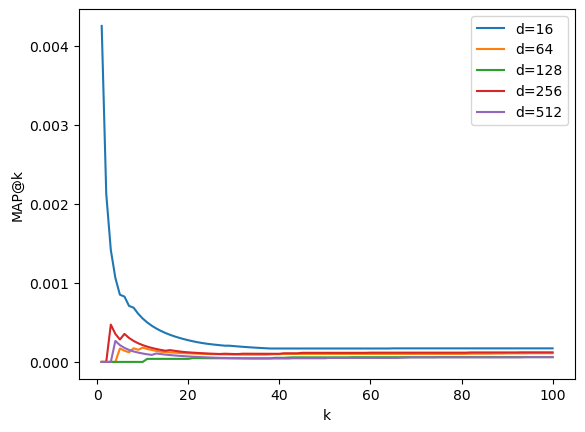

In [62]:
d_values = [16, 64, 128, 256, 512]
ks = list(range(1, 101))
num_iters = 20

results = []

for d in d_values:
    model = HiddenVars(train_ratings, dim=d, mode='sgd')
    model.fit(num_iters=num_iters)
    pred_recs = model.get_test_recommendations(max(ks))
    for k in ks:
        results_random = []
        test_recommendation = test_ratings.groupby('userId')['trackId'].apply(list)

        mapk_ = mapk(list(test_recommendation), pred_recs, k)
        
        results.append((d, k, mapk_))

best_params = max(results, key=lambda x: x[2])

print(f"Best parameters: dimension={best_params[0]}, k={best_params[1]} with MAP@k={best_params[2]}")

# Построение графиков
for d in d_values:
    map_scores = [r[2] for r in results if r[0] == d]
    plt.plot(ks, map_scores, label=f'd={d}')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Best parameters: dimension=32, k=1 with MAP@k=0.00425531914893617


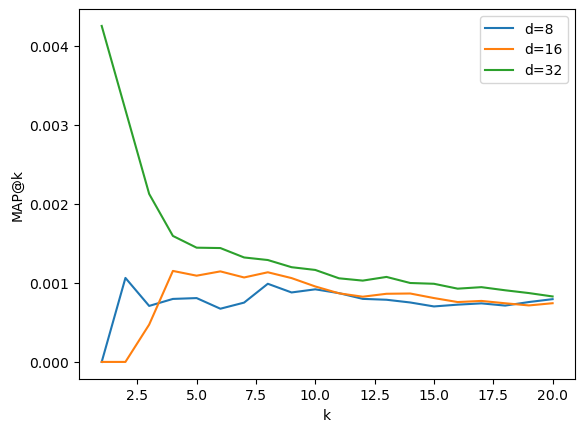

In [ ]:
d_values = [8, 16, 32]
ks = list(range(1, 21))
num_iters = 10

results = []

for d in d_values:
    model = HiddenVars(train_ratings, dim=d, mode='als')
    model.fit(num_iters=num_iters)
    pred_recs = model.get_test_recommendations(max(ks))
    for k in ks:
        results_random = []
        test_recommendation = test_ratings.groupby('userId')['trackId'].apply(list)

        mapk_ = mapk(list(test_recommendation), pred_recs, k)
        
        results.append((d, k, mapk_))

best_params = max(results, key=lambda x: x[2])

print(f"Best parameters: dimension={best_params[0]}, k={best_params[1]} with MAP@k={best_params[2]}")

# Построение графиков
for d in d_values:
    map_scores = [r[2] for r in results if r[0] == d]
    plt.plot(ks, map_scores, label=f'd={d}')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend()
plt.show()

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
5517,Варвара,['Би-2'],0.649796
17328,Я хочу быть с тобой,['Nautilus Pompilius'],0.646846
2058,Последний герой,['КИНО'],0.640997
5872,Я свободен,['Кипелов'],0.606749
2060,Хочу перемен,['КИНО'],0.603231
5515,Романс,['Сплин'],0.590318
24284,Как на войне,['Агата Кристи'],0.586219
4463,Holiday,['Green Day'],0.576644
2179,Восьмиклассница,['КИНО'],0.570639
